In [11]:
library(rugarch)
require(xts)
data(spyreal)
spec = ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = FALSE), variance.model = list(model = 'realGARCH', garchOrder = c(2, 1)))
setbounds(spec)<-list(alpha2=c(-1,1))
fit = ugarchfit(spec, spyreal[, 1] * 100, solver = 'hybrid', realizedVol = spyreal[,2] * 100)

cf = coef(fit)
se = fit@fit$matcoef[, 2]
names(se) = names(cf)
# HHS2012 divide the period into in-(T=1492) and out- of sample, even though they are estimating the model using the entire dataset (T=1659)...no comment.
benchmark.LL = c('logL' = -2388.75, 'pLogL' = -1710.34)
benchmark.pars = c('logh0' = -0.289213754, 'omega' = 0.041246175, 'alpha1' = 0.450676773, 'alpha2' = -0.176042911, 'beta1' = 0.701210369, 'xi' = -0.179994885, 'delta' = 1.037491982, 'eta1' = -0.067809509, 'eta2' = 0.07015778, 'lambda' = sqrt(0.145369801))
benchmark.se = c('logh0' = 0.278787604, 'omega' = 0.015515016, 'alpha1' = 0.038027571, 'alpha2' = 0.06335417, 'beta1' = 0.055974942, 'xi' = 0.043611245, 'delta' = 0.057726499, 'eta1' = 0.010309694, 'eta2' = 0.006620828, 'lambda' = 0.00594321)
# rugarch does not estimate h0, instead uses either mean(residuals^2), else a choice of variance targeting with options
rugarch.LL = c('logL' = sum(-fit@fit$log.likelihoods[1:1492]), 'pLogL' = sum(-fit@fit$partial.log.likelihoods[1:1492]))
rugarch.pars = c('logh0' = NA, 'omega' = cf['omega'], 'alpha1' = cf['alpha1'], 'alpha2' = cf['alpha2'], 'beta1' = cf['beta1'], 'xi' = cf['xi'], 'delta' = cf['delta'], 'eta1' = cf['eta11'], 'eta2' = cf['eta21'], 'lambda' = cf['lambda'])
rugarch.se = c('logh0' = NA, 'omega' = se['omega'], 'alpha1' = se['alpha1'], 'alpha2' = se['alpha2'], 'beta1' = se['beta1'], 'xi' = se['xi'], 'delta' = se['delta'], 'eta1' = se['eta11'], 'eta2' = se['eta21'], 'lambda' = se['lambda'])
names(rugarch.pars) = names(rugarch.se) = c('logh0', 'omega', 'alpha1', 'alpha2', 'beta1', 'xi', 'delta', 'eta1', 'eta2', 'lambda')
parsdf = cbind(benchmark.pars, rugarch.pars, benchmark.pars - rugarch.pars)
sedf = cbind(benchmark.se, rugarch.se, benchmark.se - rugarch.se)
LRE.vars = -log(abs(rugarch.pars - benchmark.pars)/abs(benchmark.pars), base = 10)
LRE.se = -log(abs(rugarch.se - benchmark.se)/abs(benchmark.se), base = 10)
test = cbind(LRE.vars, LRE.se)
tmp1 = t(cbind(rugarch = rugarch.pars, benchmark = benchmark.pars))
tmp2 = t(cbind(rugarch = rugarch.se, benchmark = benchmark.se))
# (round(t(cbind(rugarch.pars, benchmark.pars)),4))
# print(tmp1)
# print(tmp2)
# print the results:
# parameters:
#             logh0  omega alpha1  alpha2  beta1      xi delta    eta1   eta2  lambda
# rugarch        NA 0.0451 0.4766 -0.2027 0.7050 -0.1898 1.027 -0.0616 0.0718  0.3815
# benchmark -0.2892 0.0412 0.4507 -0.1760 0.7012 -0.1800 1.038 -0.0678 0.0702  0.3813
#
# standard errors:
#            logh0  omega alpha1 alpha2  beta1     xi  delta   eta1   eta2 lambda
# rugarch       NA 0.0137 0.0289 0.0450 0.0381 0.0390 0.0403 0.0097 0.0062 0.0066
# benchmark 0.2788 0.0155 0.0380 0.0634 0.0560 0.0436 0.0577 0.0103 0.0066 0.0059
#
# Log Relative Error Test:
#          logh0  omega alpha1 alpha2  beta1     xi delta  eta1  eta2 lambda
# LRE.vars    NA 1.0293 1.2408 0.8191 2.2627 1.2640 2.012 1.041 1.623 3.1413
# LRE.se      NA 0.9355 0.6212 0.5374 0.4947 0.9733 0.519 1.204 1.208 0.9435

fit = ugarchfit(spec, spyreal[, 1] * 100, out.sample = 25, solver = 'hybrid', realizedVol = spyreal[, 2] * 100)
specf = spec
setfixed(specf) <- as.list(coef(fit))
filt = ugarchfilter(specf, data = spyreal[, 1] * 100, n.old = nrow(spyreal) - 25, realizedVol = spyreal[, 2] * 100)
forc1 = ugarchforecast(fit, n.ahead = 1, n.roll = 25)
# forecast from spec
forc2 = ugarchforecast(specf, n.ahead = 1, n.roll = 25, data = spyreal[, 1] * 100, out.sample = 25, realizedVol = spyreal[, 2] * 100)
filts = tail(sigma(filt), 25)
colnames(filts) = 'filter'
forcs1 = xts(sigma(forc1)[1, ], move(as.Date(names(sigma(forc1)[1, ])), by = 1))
forcs2 = xts(sigma(forc2)[1, ], move(as.Date(names(sigma(forc2)[1, ])), by = 1))
colnames(forcs1) = 'fit2forecast'
colnames(forcs2) = 'spec2forecast'
ftest = cbind(filts, forcs1, forcs2)
# last forecast is completely out of sample, so not available from the
# filter method (which filters given T-1)
# print(round(ftest, 5))
##            filter fit2forecast spec2forecast
## 2008-07-28 1.1065       1.1065        1.1065
## 2008-07-29 1.0131       1.0131        1.0131
## 2008-07-30 0.9885       0.9885        0.9885
## 2008-07-31 1.0828       1.0828        1.0828
## 2008-08-01 1.0685       1.0685        1.0685
## 2008-08-04 1.1434       1.1434        1.1434
## 2008-08-05 1.0460       1.0460        1.0460
## 2008-08-06 1.0351       1.0351        1.0351
## 2008-08-07 0.9206       0.9206        0.9206
## 2008-08-08 0.9933       0.9933        0.9933
## 2008-08-11 1.0083       1.0083        1.0083
## 2008-08-12 0.9368       0.9368        0.9368
## 2008-08-13 0.9564       0.9564        0.9564
## 2008-08-14 1.0243       1.0243        1.0243
## 2008-08-15 0.9903       0.9903        0.9903
## 2008-08-18 0.9432       0.9432        0.9432
## 2008-08-19 0.9751       0.9751        0.9751
## 2008-08-20 0.9453       0.9453        0.9453
## 2008-08-21 1.0326       1.0326        1.0326
## 2008-08-22 0.9930       0.9930        0.9930
## 2008-08-25 0.8638       0.8638        0.8638
## 2008-08-26 0.9082       0.9082        0.9082
## 2008-08-27 0.9154       0.9154        0.9154
## 2008-08-28 0.8658       0.8658        0.8658
## 2008-08-29 0.8235       0.8235        0.8235
## 2008-09-01     NA       0.8103        0.8103

# ni = newsimpact(fit, z = seq(-2, 2, length.out = 100))
# plot(ni$zx, (ni$zy), ylab = ni$yexpr, xlab = ni$xexpr, type = 'l', main = 'News Impact realGARCH')
# abline(v = 0)
# abline(h = 0)
# grid()

set.seed(55)
# forc3 = ugarchforecast(fit, n.ahead = 400, n.sim = 5000)
# plot <- plot(sigma(forc3), type = 'l', main = 'realGARCH long-run forecast')
# abline(h = sqrt(uncvariance(fit)), col = 2)
# legend('topright', c('long-run forecast', 'unconditional value'), col = 1:2, lty = c(1, 1), bty = 'n')

set.seed(55)
forc4 = ugarchforecast(fit, out.sample = 0, n.ahead = 25, n.sim = 10000)
# dim(forc4@forecast$sigmaDF)
sigmaDF = forc4@forecast$sigmaDF
meansig = sqrt(exp(rowMeans(log(sigmaDF[, , 1]^2))))
# boxplot(t(sigmaDF[, , 1]), main = '25-ahead volatility forecast (realGARCH)', col = 'orange')
# points(as.numeric(meansig), col = 'green')
# note that for the 1-ahead there is no uncertainty (unless we were doing this Bayes-style so that parameter uncertainty would have an impact).

library(parallel)
cl = makePSOCKcluster(5)
spec1 = ugarchspec(mean.model = list(armaOrder = c(1, 1), include.mean = TRUE), variance.model = list(model = 'realGARCH', garchOrder = c(1, 1)))
spec2 = ugarchspec(mean.model = list(armaOrder = c(1, 1), include.mean = TRUE), variance.model = list(model = 'eGARCH', garchOrder = c(1, 1)))
roll1 = ugarchroll(spec1, spyreal[, 1] * 100, forecast.length = 500, solver = 'hybrid', refit.every = 25, refit.window = 'recursive', realizedVol = spyreal[, 2] * 100, cluster = cl)
roll2 = ugarchroll(spec2, spyreal[, 1] * 100, forecast.length = 500, refit.every = 25, refit.window = 'recursive', cluster = cl)
# report(roll1)
## VaR Backtest Report
## ===========================================
## Model:           realGARCH-norm
## Backtest Length: 500
## Data:
##
## ==========================================
## alpha:               1%
## Expected Exceed:     5
## Actual VaR Exceed:   10
## Actual %:            2%
##
## Unconditional Coverage (Kupiec)
## Null-Hypothesis: Correct Exceedances
## LR.uc Statistic: 3.914
## LR.uc Critical:  3.841
## LR.uc p-value:   0.048
## Reject Null:     YES
##
## Conditional Coverage (Christoffersen)
## Null-Hypothesis: Correct Exceedances and
##                  Independence of Failures
## LR.cc Statistic: 4.323
## LR.cc Critical:  5.991
## LR.cc p-value:   0.115
## Reject Null:     NO
##
##
# report(roll2)
## VaR Backtest Report
## ===========================================
## Model:           eGARCH-norm
## Backtest Length: 500
## Data:
##
## ==========================================
## alpha:               1%
## Expected Exceed:     5
## Actual VaR Exceed:   16
## Actual %:            3.2%
##
## Unconditional Coverage (Kupiec)
## Null-Hypothesis: Correct Exceedances
## LR.uc Statistic: 15.467
## LR.uc Critical:  3.841
## LR.uc p-value:   0
## Reject Null:     YES
##
## Conditional Coverage (Christoffersen)
## Null-Hypothesis: Correct Exceedances and
##                  Independence of Failures
## LR.cc Statistic: 16.527
## LR.cc Critical:  5.991
## LR.cc p-value:   0
## Reject Null:     YES
##
##
# par(new=TRUE)


In [30]:
library(rugarch)
library(ggplot2)
library(dplyr)
require(xts)


In [65]:
data(spyreal)
spec = ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = FALSE), variance.model = list(model = 'realGARCH', garchOrder = c(2, 1)))
setbounds(spec)<-list(alpha2=c(-1,1))
fit = ugarchfit(spec, spyreal[, 1] * 100, solver = 'hybrid', realizedVol = spyreal[,2] * 100)
forc = ugarchforecast(fit, n.ahead = 1000)


In [66]:
forecast_data <- forc@forecast$sigmaFor
start_date <- as.Date(unlist(dimnames(forc@forecast$sigmaFor)[2])) + 1
n_forecast <- length(forecast_data)
forecast_dates <- seq.Date(from = start_date, by = "day", length.out = n_forecast)
forecast_xts <- xts(forecast_data, order.by = forecast_dates)


In [70]:
print(uncvariance(fit))
print(uncvariance(forc))


[1] 0.604494


ERROR: Error in UseMethod("uncvariance"): no applicable method for 'uncvariance' applied to an object of class "c('uGARCHforecast', 'GARCHforecast', 'rGARCH')"


Warning message:
“Removed 1000 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 50 rows containing missing values or values outside the scale range
(`geom_line()`).”


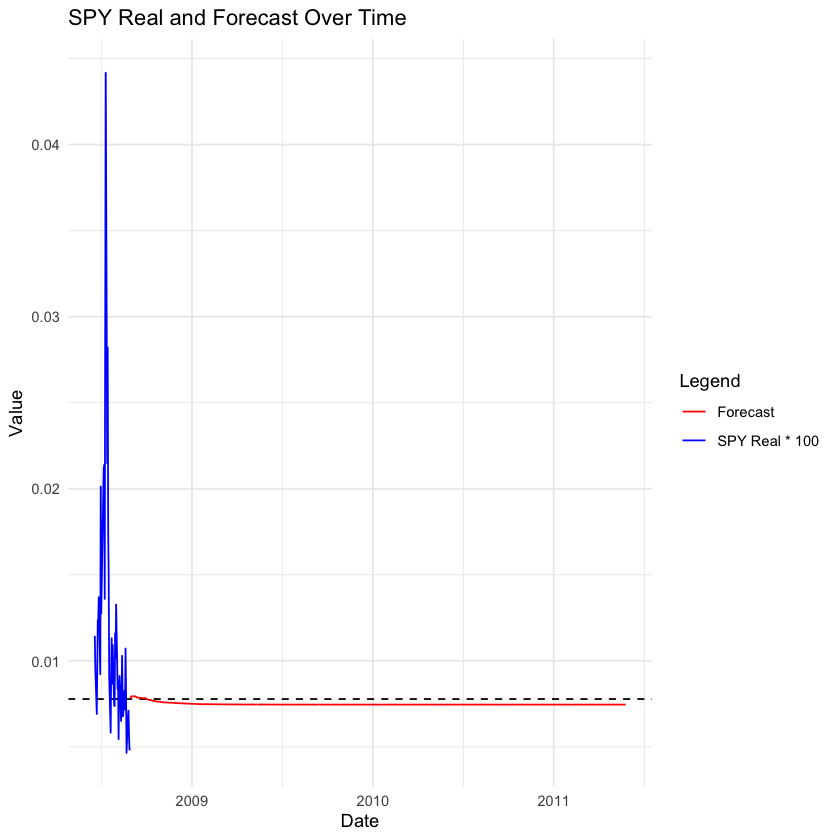

In [68]:
spyreal_df <- data.frame(Date = index(spyreal), spyreal_value = coredata(spyreal[, 2]))
forecast_df <- data.frame(Date = index(forecast_xts), forecast_value = coredata(forecast_xts) / 100)
combined_df <- full_join(tail(spyreal_df,50), forecast_df, by = "Date")
colnames(combined_df) <- c("date", "spyreal_value", "forecast_value")
ggplot(combined_df, aes(x = date)) +
	geom_hline(yintercept = sqrt(uncvariance(fit)) / 100, linetype = "dashed", color = "black") +
	geom_line(aes(y = spyreal_value, color = "SPY Real * 100")) +
	geom_line(aes(y = forecast_value, color = "Forecast")) +
	labs(title = "SPY Real and Forecast Over Time",
		y = "Value",
		x = "Date") +
	scale_color_manual(name = "Legend", values = c("SPY Real * 100" = "blue", "Forecast" = "red")) +
	theme_minimal()


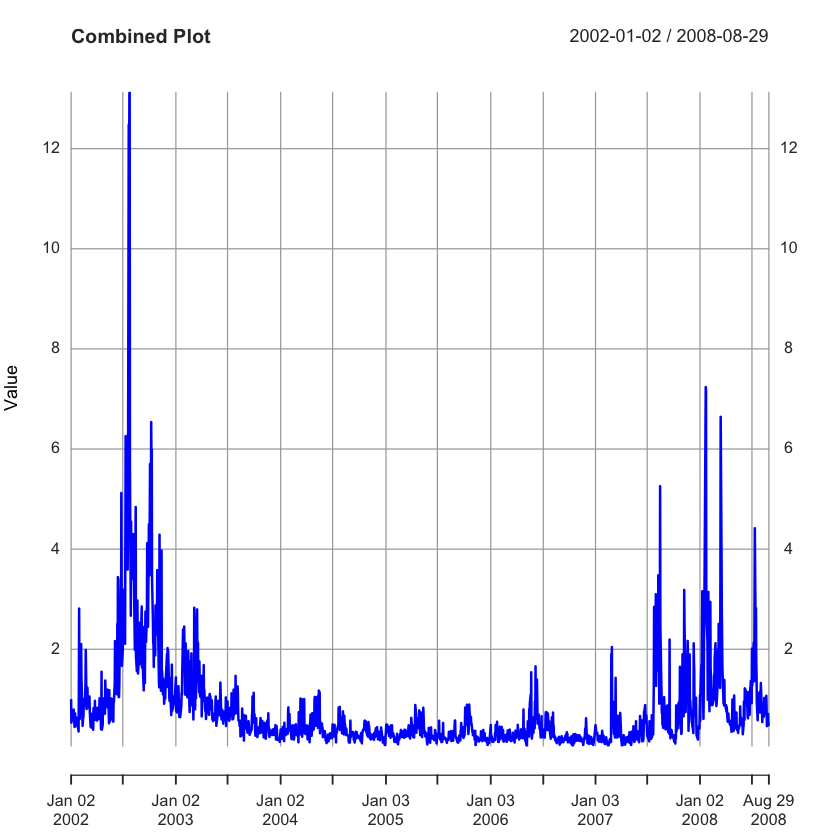

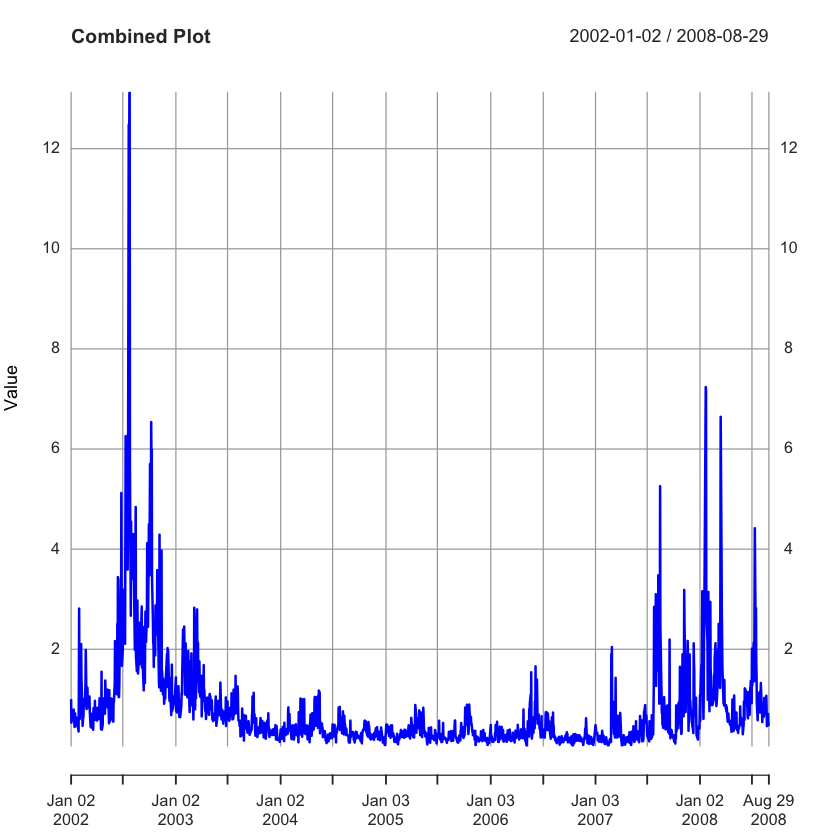

In [26]:
plot(as.xts(spyreal[, 2] * 100), type='l', col = 'blue', ylab = "Value", xlab = "Index", main = "Combined Plot",  auto.grid = FALSE, minor.ticks = FALSE)
lines(forecast_xts, col = 'green')
# plot(as.xts(as.data.frame(roll1)[, 'Sigma', drop = FALSE]), col='red', main = 'realGARCH vs eGARCH\n(out-of-sample volatility forecast)')
# lines(as.xts(as.data.frame(roll2)[, 'Sigma', drop = FALSE]), col = 'green')
grid()


In [9]:
seq.Date(from = start_date, by = "day", length.out = n_forecast+1)


[1] "2008-08-29" "2008-08-30" "2008-08-31" "2008-09-01" "2008-09-02"
 [6] "2008-09-03" "2008-09-04" "2008-09-05" "2008-09-06" "2008-09-07"
[11] "2008-09-08" "2008-09-09" "2008-09-10" "2008-09-11" "2008-09-12"
[16] "2008-09-13" "2008-09-14" "2008-09-15" "2008-09-16" "2008-09-17"
[21] "2008-09-18" "2008-09-19" "2008-09-20" "2008-09-21" "2008-09-22"
[26] "2008-09-23"

In [7]:
library(ggplot2)
library(dplyr)
spyreal_df <- data.frame(Date = index(spyreal), spyreal_value = coredata(spyreal[, 2]) * 100)
forecast_df <- data.frame(Date = index(forecast_xts), forecast_value = coredata(forecast_xts))
combined_df <- full_join(spyreal_df, forecast_df, by = "Date")
combined_df
# ggplot(combined_df, aes(x = Date)) +
# 	geom_line(aes(y = spyreal_value, color = "SPY Real * 100")) +
# 	geom_line(aes(y = forecast_value, color = "Forecast")) +
# 	labs(title = "SPY Real and Forecast Over Time",
# 		y = "Value",
# 		x = "Date") +
# 	scale_color_manual(name = "Legend", values = c("SPY Real * 100" = "blue", "Forecast" = "red")) +
# 	theme_minimal()


Date,SPY_RK,X2008.07.25
<date>,<dbl>,<dbl>
2002-01-02,1.0044750,NA
2002-01-03,0.5342828,NA
2002-01-04,0.7978535,NA
2002-01-07,0.5772834,NA
2002-01-08,0.6452759,NA
2002-01-09,0.7684824,NA
2002-01-10,0.6758436,NA
2002-01-11,0.7943755,NA
2002-01-14,0.4499605,NA


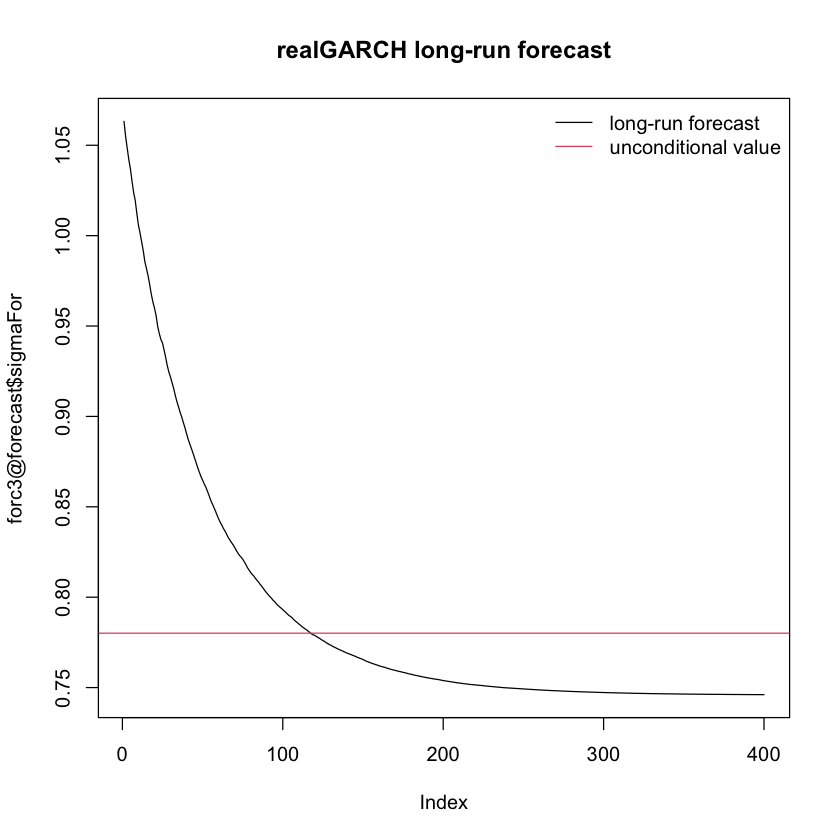

In [28]:
forc3 = ugarchforecast(fit, n.ahead = 400, n.sim = 5000)
plot <- plot(forc3@forecast$sigmaFor, type = 'l', main = 'realGARCH long-run forecast')
abline(h = sqrt(uncvariance(fit)), col = 2)
legend('topright', c('long-run forecast', 'unconditional value'), col = 1:2, lty = c(1, 1), bty = 'n')


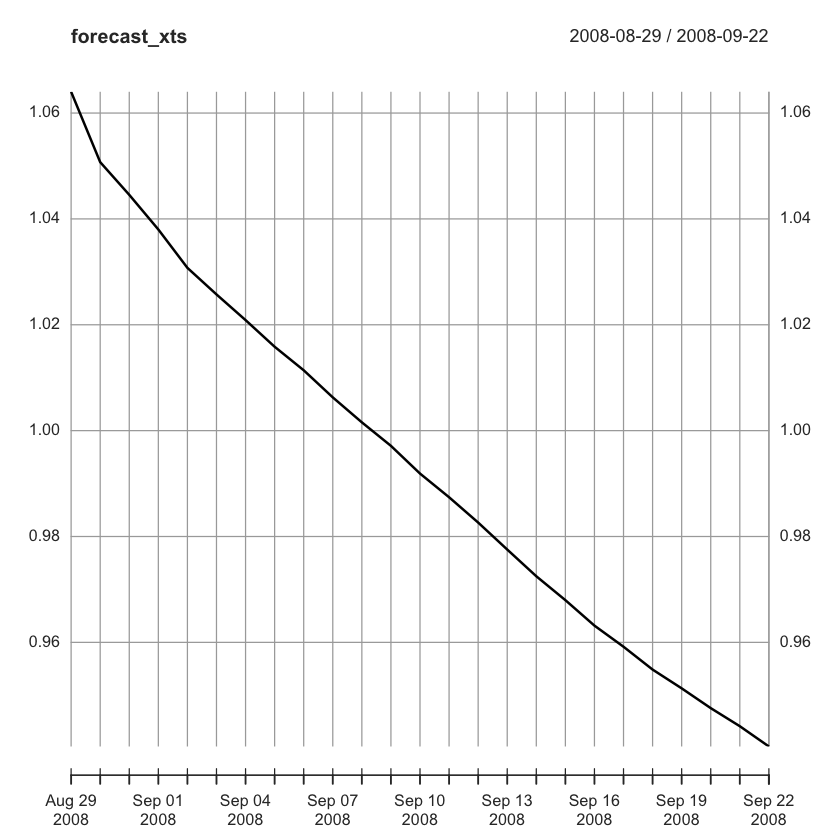

In [31]:
forecast_data <- forc4@forecast$sigmaFor
start_date <- as.Date("2008-08-29")  # Replace with your actual start date
n_forecast <- length(forecast_data)
forecast_dates <- seq.Date(from = start_date, by = "day", length.out = n_forecast)

# Combine the forecast data and dates into an xts object
forecast_xts <- xts(forecast_data, order.by = forecast_dates)
plot(forecast_xts)


In [27]:
as.data.frame(forc4@forecast$sigmaFor)


,2008-07-25
,<dbl>
T+1,1.0640186
T+2,1.0507283
T+3,1.0445495
T+4,1.0380030
T+5,1.0307531
T+6,1.0257353
T+7,1.0208839
T+8,1.0158505
T+9,1.0114033


In [24]:
forc4@forecast$sigmaFor
# plot(as.xts(forc4@forecast$sigmaFor))


,2008-07-25
T+1,1.0640186
T+2,1.0507283
T+3,1.0445495
T+4,1.0380030
T+5,1.0307531
T+6,1.0257353
T+7,1.0208839
T+8,1.0158505
T+9,1.0114033
T+10,1.0062830
